Notebook showcasing the algorithm in our ODfunctions library. Please make sure the working directory is where the "ODfunctions.py" file is and all the required librairies are installed.

In [1]:
import os as os
os.chdir(".") #Working directory where the "ODfunctions.py" file is.
from ODfunctions import OptDesign, DOGS, LSA, ExM, Discrete_ExM, PHImono, PHImono_show #Requires the packages: math, numpy,
#cvxopt, matplotlib, scipy and dppy.
import numpy as np
import matplotlib.pyplot as plt
import time as time

# 1. Rectangular Design Spaces

In order to define any optimal design object, we need a function *PHI* that takes any $n\times d$ array of the form
$$\begin{pmatrix}x_1\\ \vdots\\ x_n\end{pmatrix},$$
where $d$ is the dimension of the design space, and returns the array
$$\begin{pmatrix}\phi_1(x_1) & \cdots & \phi_p(x_1) \\ \vdots & \ddots & \vdots \\ \phi_1(x_n) & \cdots &
\phi_p(x_n)\end{pmatrix}$$
where the $\phi_i$ are the regressing functions.
Included in the package is the function *PHImono(dim,deg)* that does this job when the $\phi_i$ are the *dim*-dimensional multinomials with degree <*deg*.

In [2]:
PHI = PHImono(2, 3)

PHImono_show(2, 3) #Shows the order of the polynomials in the PHImono functions.

1
x
x²
x³
y
xy
x²y
y²
xy²
y³


We can then define an OD object when the design space is a rectangular window
$$[x_1,y_1]\times\cdots\times[x_d,y_d]$$
using the syntax *OptDesign(PHI , $[x_1,\cdots,x_n]$ , $[y_1,\cdots,y_n]$ , nbpoint=None)*. nbpoint corresponds to the number of points in the designs we consider. If not specified, it defaults to being equal to the number of regressing functions.

log D-optimality criterion for this random design chosen with a uniform distribution: 58.328128018539395
A-optimality criterion for this random design chosen with a uniform distribution: 5127795355.110041


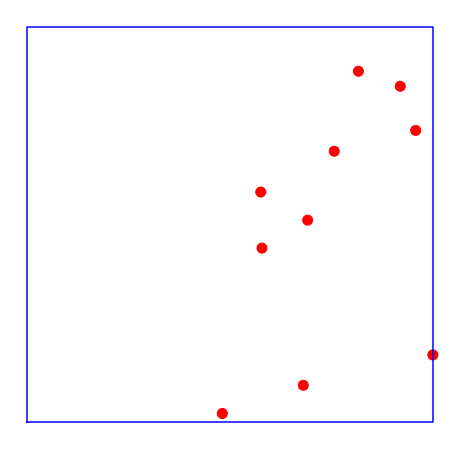

In [3]:
OD = OptDesign(PHI, [0, 0], [1, 1]) #Here, nbpoint default to 10, the number of regressing functions in PHI.
OD_50pts = OptDesign(PHI, [0, 0], [1, 1], nbpoint=50)

P = OD.Urand(10) #Generates a random 10-points design uniformly in the design space
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P, crit = "D")) #Shows the log of its D-optimality criterion. If crit is not specified, it defaults to
#the D-optimality criterion.
print("A-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P, crit = "A")) #Shows its A-optimality criterion.
OD.plot(P) #Plots the design (only in dimension 2).

It is possible to consider a Bayesian setting with the parameter *A_prior* specifing the inverse covariance matrix of the prior. It has to be a $p\times p$ positive semi-definite matrix. If that matrix is for the form *cst $\times$ identity*, it is possible to only specify *A_prior=cst*.

In [4]:
OD_Bayesian = OptDesign(PHI, [0, 0], [1, 1], nbpoint=50, A_prior=100) #Prior with covariance matrix of 0.01*I_{10}

## 1.1. DOGS

The only parameter required to defined the DOGS algorithm is the OD problem associated. Additional parameters includes the number of points generated for each update of the algorithm (equals to nbpoint by default), the initial design of the algorithm (generated randomly uniformly by default), the optimality criterion (D-optimality by default) and potential candidate points. The syntax is *DOGS(OptDesign , nbupd=None , ini=None , crit="D", CP=None)*

In [5]:
Algo = DOGS(OD)
Algo_100upd = DOGS(OD, nbupd = 100)
Algo_50pts = DOGS(OD_50pts)
Algo_Bayesian = DOGS(OD_Bayesian)
CP = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Algo_50pts_withCP = DOGS(OD_50pts, CP=CP)

To get one simulation of DOGS, the syntax is *DOGS.simulate(nbiter , progress=False)* where *nbiter* is the number of iteration of the algorithm and *progress* indicates whether the algorithms shows its progression or not.

log D-optimality criterion for one realization of Algo after 100 iterations: 23.122
log D-optimality criterion for one realization of Algo_100upd after 100 iterations: 22.318


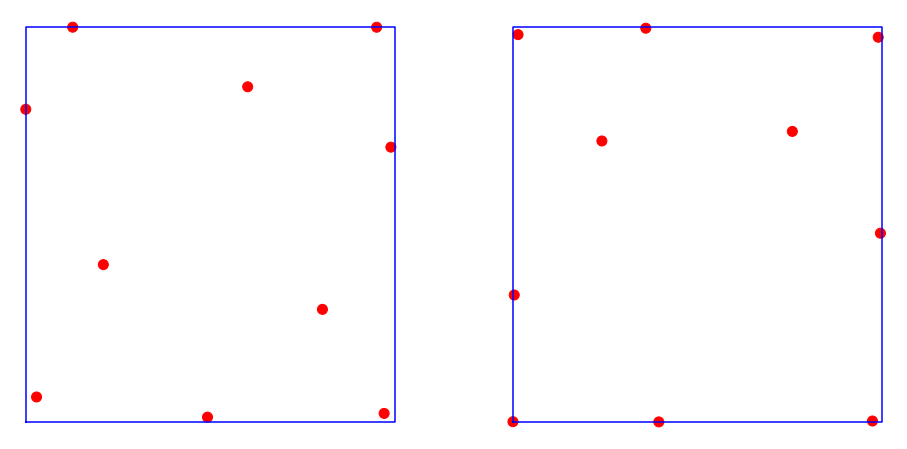

log D-optimality criterion for one realization of Algo_50pts after 100 iterations: 6.608
log D-optimality criterion for one realization of Algo_50pts_withCP after 100 iterations: 5.522


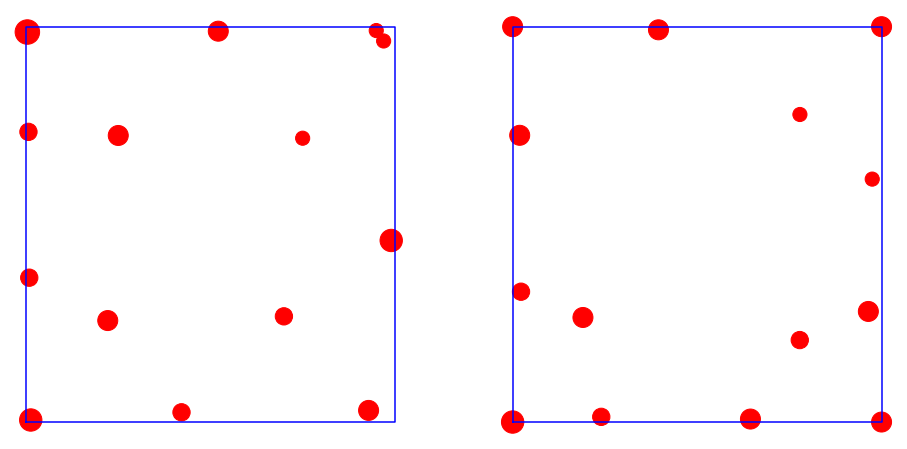

In [6]:
P1 = Algo.simulate(100)
print("log D-optimality criterion for one realization of Algo after 100 iterations:", end=" ")
print(f'{OD.opt(P1, crit="D"):.3f}')

P2 = Algo_100upd.simulate(100)
print("log D-optimality criterion for one realization of Algo_100upd after 100 iterations:", end=" ")
print(f'{OD.opt(P2, crit="D"):.3f}')

OD.plot((P1, P2))

P3 = Algo_50pts.simulate(100)
print("log D-optimality criterion for one realization of Algo_50pts after 100 iterations:", end=" ")
print(f'{OD_50pts.opt(P3, crit="D"):.3f}')

P4 = Algo_50pts_withCP.simulate(100)
print("log D-optimality criterion for one realization of Algo_50pts_withCP after 100 iterations:", end=" ")
print(f'{OD_50pts.opt(P4, crit="D"):.3f}')

OD_50pts.plot((P3, P4)) #The size of the markers is proportional to the number of times each point appears in the design.

log D-optimality criterion for one realization of Algo_Bayesian after 100 iterations: 2.977


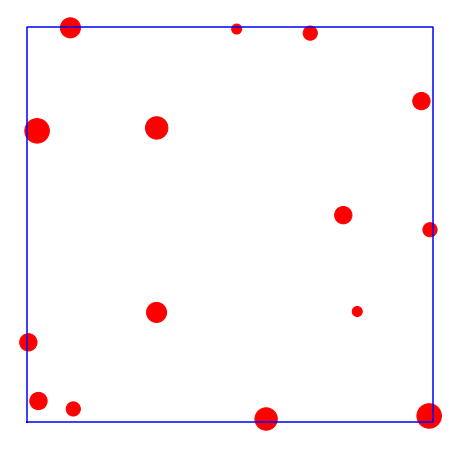

In [7]:
P = Algo_Bayesian.simulate(100)
print("log D-optimality criterion for one realization of Algo_Bayesian after 100 iterations:", end=" ")
print(f'{OD_Bayesian.opt(P, crit="D"):.3f}')
OD_Bayesian.plot(P)

In order to see the evolution of the optimality criterion w.r.t. the number of iterations across various simulation of the algorithm, we can use *DOGS.testing(nbiter , nbtest=1 , progress=False)* where *nbiter* is the number of iteration and *nbtest* the number of testing. Since it can be a bit long, adding *progress=True* shows the evolution of the algorithm.

Progress: 100.00% Done


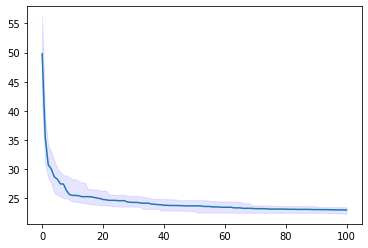

In [8]:
L = Algo.testing(100, 20, progress=True)
M = np.median(L, axis=0) #Computes the median optimality criterion with respect to the number of iterations.
Q_low = np.quantile(L, 0.05, axis=0) 
Q_high = np.quantile(L, 0.95, axis=0) #Computes the 5% and 95% quantile of the optimality criterion with respect to 
#the number of iterations.
plt.plot(M)
plt.fill_between(np.arange(101), Q_low, Q_high, color='b', alpha=.1);

## 1.2. Local Search Algorithm

The LSA algorithm is defined by the OD problem associated and the standard deviation $\sigma$ of the gaussian random walk. Additional parameters includes the initial design of the algorithm (generated randomly uniformly by default) and the optimality criterion (D-optimality by default). The syntax is *LSA(OptDesign , stdev , ini=None , crit="D")*

In [9]:
Algo = LSA(OD, 0.02)
Algo_50pts = LSA(OD_50pts, 0.02)
Algo_Bayesian = LSA(OD_Bayesian, 0.02)

The syntax for its simulation and testings are the same than for DOGS.

log D-optimality criterion for one realization of Algo after 2000 iterations: 21.689


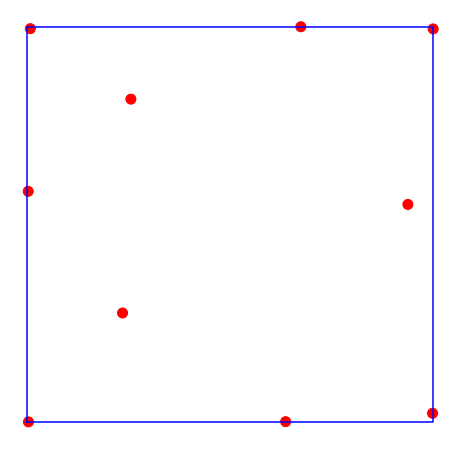

log D-optimality criterion for one realization of Algo_50pts after 2000 iterations: 7.359


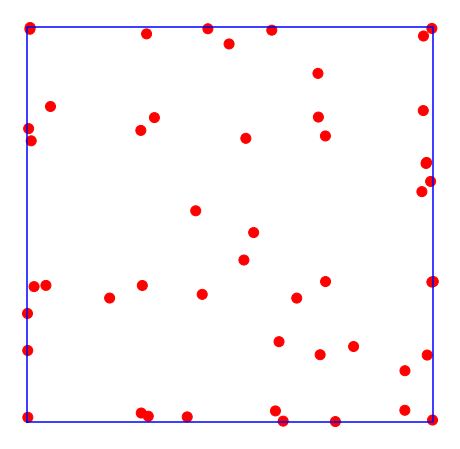

log D-optimality criterion for one realization of Algo_Bayesian after 2000 iterations: 3.410


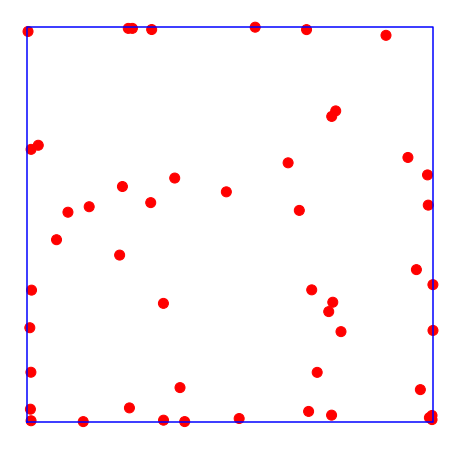

In [10]:
P1 = Algo.simulate(2000) #The algorithm converges slowly but is very fast to execute which 
#allows us to easily run many more iterations than DOGS.
print("log D-optimality criterion for one realization of Algo after 2000 iterations:", end=" ")
print(f'{OD.opt(P1, crit="D"):.3f}')
OD.plot(P1)

P2 = Algo_50pts.simulate(2000)
print("log D-optimality criterion for one realization of Algo_50pts after 2000 iterations:", end=" ")
print(f'{OD_50pts.opt(P2, crit="D"):.3f}')
OD_50pts.plot(P2)

P3 = Algo_Bayesian.simulate(2000)
print("log D-optimality criterion for one realization of Algo_Bayesian after 2000 iterations:", end=" ")
print(f'{OD_Bayesian.opt(P2, crit="D"):.3f}')
OD_Bayesian.plot(P3)

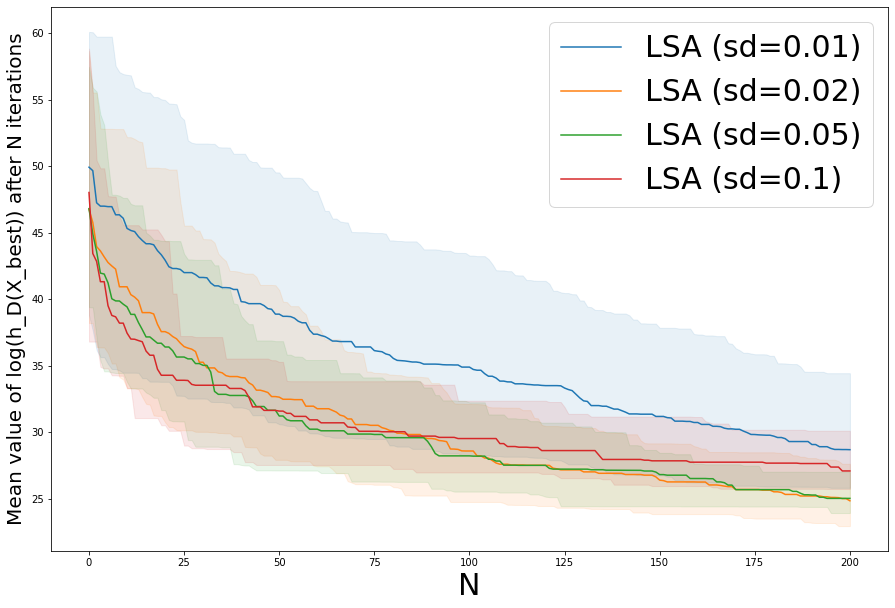

In [11]:
Algo_sd1 = LSA(OD, 0.01)  #Testing the performance of LSA with various standard deviations
Algo_sd2 = LSA(OD, 0.02)
Algo_sd5 = LSA(OD, 0.05)
Algo_sd10 = LSA(OD, 0.1)

L1 = Algo_sd1.testing(200, 20)
M1 = np.median(L1, axis=0)
Q1_low = np.quantile(L1, 0.05, axis=0) 
Q1_high = np.quantile(L1, 0.95, axis=0)

L2 = Algo_sd2.testing(200, 20)
M2 = np.median(L2, axis=0)
Q2_low = np.quantile(L2, 0.05, axis=0) 
Q2_high = np.quantile(L2, 0.95, axis=0)

L3 = Algo_sd5.testing(200, 20)
M3 = np.median(L3, axis=0)
Q3_low = np.quantile(L3, 0.05, axis=0) 
Q3_high = np.quantile(L3, 0.95, axis=0)

L4 = Algo_sd10.testing(200, 20)
M4 = np.median(L4, axis=0)
Q4_low = np.quantile(L4, 0.05, axis=0) 
Q4_high = np.quantile(L4, 0.95, axis=0)

plt.figure(figsize=(15, 10))
plt.plot(M1)
plt.plot(M2)
plt.plot(M3)
plt.plot(M4)
plt.fill_between(np.arange(201), Q1_low, Q1_high, color='C0', alpha=.1);
plt.fill_between(np.arange(201), Q2_low, Q2_high, color='C1', alpha=.1);
plt.fill_between(np.arange(201), Q3_low, Q3_high, color='C2', alpha=.1);
plt.fill_between(np.arange(201), Q4_low, Q4_high, color='C3', alpha=.1);
plt.legend(labels = ["LSA (sd=0.01)", "LSA (sd=0.02)", "LSA (sd=0.05)", "LSA (sd=0.1)"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20);

## 1.3. Exchange Method

The only parameter required to defined the ExM algorithm is the OD problem associated. Additional parameters includes the initial design of the algorithm (generated randomly uniformly by default) and the optimality criterion (D-optimality by default). The syntax is *ExM(OptDesign , ini=None , crit="D")*

In [12]:
Algo = ExM(OD)
Algo_50pts = ExM(OD_50pts)
Algo_Bayesian = ExM(OD_Bayesian)

The syntax for its simulation and testings are the same than for ARIFAA.

log D-optimality criterion for one realization of Algo after 100 iterations: 21.640


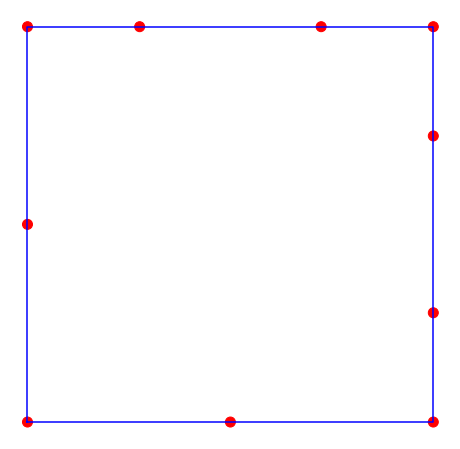

log D-optimality criterion for one realization of Algo_50pts after 100 iterations: 4.733


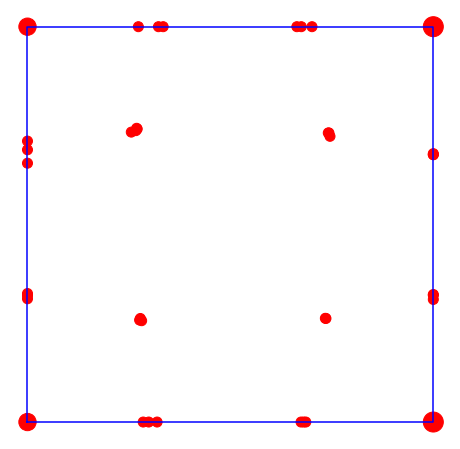

log D-optimality criterion for one realization of Algo_Bayesian after 100 iterations: 1.577


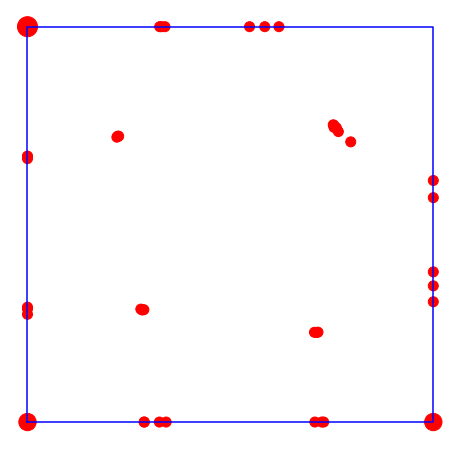

In [13]:
P1 = Algo.simulate(100) #This algorithm is very efficient when the design space is rectangular 
#and the regressing functions are multinomials.
print("log D-optimality criterion for one realization of Algo after 100 iterations:", end=" ")
print(f'{OD.opt(P1, crit="D"):.3f}')
OD.plot(P1)

P2 = Algo_50pts.simulate(100)
print("log D-optimality criterion for one realization of Algo_50pts after 100 iterations:", end=" ")
print(f'{OD_50pts.opt(P2, crit="D"):.3f}')
OD_50pts.plot(P2)

P3 = Algo_Bayesian.simulate(100)
print("log D-optimality criterion for one realization of Algo_Bayesian after 100 iterations:", end=" ")
print(f'{OD_Bayesian.opt(P2, crit="D"):.3f}')
OD_Bayesian.plot(P3)

/home/arnaud/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Progress: 100.00% Done


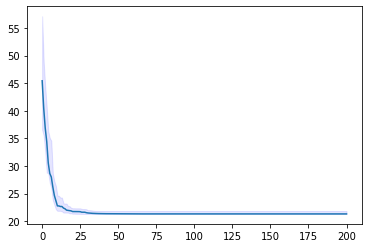

In [14]:
L = Algo.testing(200, 20, progress="True")
M = np.median(L, axis=0)
Q_low = np.quantile(L, 0.05, axis=0) 
Q_high = np.quantile(L, 0.95, axis=0)
plt.plot(M)
plt.fill_between(np.arange(201), Q_low, Q_high, color='b', alpha=.1);

# 1.4. Discrete_ExM

The Discrete ExM algorithm is defined by the OD problem associated and the set of points on which the algorithm is applied. If the integer parameter *size* is specified then the algorithm will be applied to a regular grid with *size* points in each dimension. If candidate points are specified by the parameter *CP* then the algorithm will be applied to those points. If both parameters are specified then the algorithm will use the union of both sets of points. The only additional parameter is the optimality criterion (D-optimality by default). The syntax is *Discrete_ExM(OptDesign , size = 0 , crit = "D", CP = None)*.

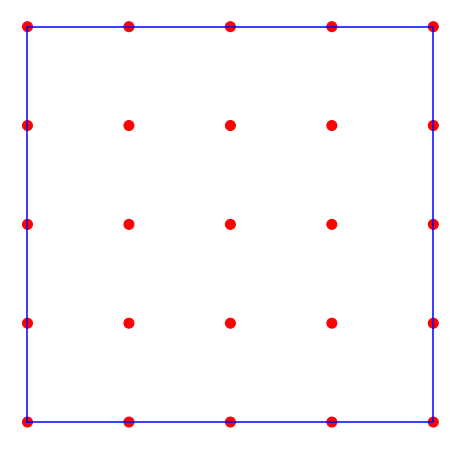

There are 25 candidate points used by Algo_5grid.


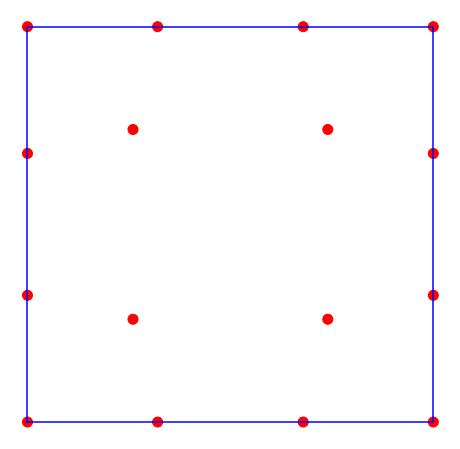

There are 16 candidate points used by Algo_2grid_withCP.


In [15]:
Algo_5grid = Discrete_ExM(OD_50pts, size=5)
Algo_5grid.show() #Plots the candidate points used by the algorithm (only in dimesnion 2)
print("There are "+str(Algo_5grid.num_point())+" candidate points used by Algo_5grid.") #Shows the number of 
#candidate point used.

a = 0.35880/2
b = 0.48/2
CP = np.array([[0.5+a, 0], [0.5-a, 0], [0.5+a, 1], [0.5-a, 1], \
               [0, 0.5+a], [0, 0.5-a], [1, 0.5+a], [1, 0.5-a], \
               [0.5+b, 0.5+b], [0.5+b, 0.5-b], [0.5-b, 0.5+b], [0.5-b, 0.5-b]]) #See "OPTIMUM MULTIVARIATE DESIGNS" 
#by Farrell et al. explaning the choice of candidate points.

Algo_2grid_withCP = Discrete_ExM(OD_50pts, size=2, CP=CP)
Algo_2grid_withCP.show()
print("There are "+str(Algo_2grid_withCP.num_point())+" candidate points used by Algo_2grid_withCP.")

The discrete Exchange method always run until it can't improve the best design it founds so there is no need to specify it's number of iterations when running it as with the other algorithms.

log D-optimality criterion for one realization of Algo_5grid after 100 iterations: 4.695
log D-optimality criterion for one realization of Algo_2grid_withCP after 100 iterations: 4.523


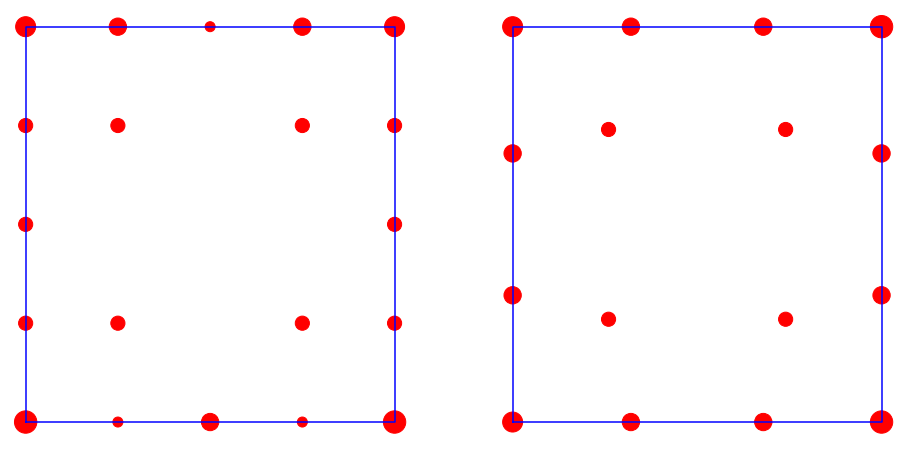

In [16]:
P1 = Algo_5grid.simulate()
print("log D-optimality criterion for one realization of Algo_5grid after 100 iterations:", end=" ")
print(f'{OD_50pts.opt(P1, crit="D"):.3f}')

P2 = Algo_2grid_withCP.simulate()
print("log D-optimality criterion for one realization of Algo_2grid_withCP after 100 iterations:", end=" ")
print(f'{OD_50pts.opt(P2, crit="D"):.3f}')

OD_50pts.plot((P1, P2))

log D-optimality criterion for one realization of Algo_5grid_Bayesian after 100 iterations: 1.572


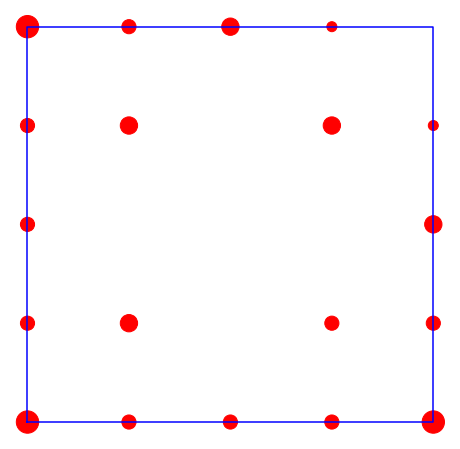

In [17]:
Algo_5grid_Bayesian = Discrete_ExM(OD_Bayesian, size=5)

P = Algo_5grid_Bayesian.simulate()
print("log D-optimality criterion for one realization of Algo_5grid_Bayesian after 100 iterations:", end=" ")
print(f'{OD_Bayesian.opt(P1, crit="D"):.3f}')

OD_Bayesian.plot(P)

# 1.5. Comparison of all algorithms

Warning! All cells in this section takes some time to compute.

In [18]:
#Comaprison in dimension 2 for polynomial regression.

PHI = PHImono(2, 3)

OD = OptDesign(PHI, [0, 0], [1, 1])
algo_tuple = (DOGS(OD), LSA(OD, 0.01), LSA(OD, 0.05), LSA(OD, 0.1), ExM(OD))
depth = 200 #Number of iteration of each algorithm.
N_test = 50 #Number of repetition of each algorithm.
quantile = 0.05 #Quantile used for plotting the shaded area.

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
    
#Testing Discrete_ExM separately.    
a = 0.35880/2
b = 0.48/2
CP = np.array([[0.5+a, 0], [0.5-a, 0], [0.5+a, 1], [0.5-a, 1], \
               [0, 0.5+a], [0, 0.5-a], [1, 0.5+a], [1, 0.5-a], \
               [0.5+b, 0.5+b], [0.5+b, 0.5-b], [0.5-b, 0.5+b], [0.5-b, 0.5-b]])

Algo_10grid_withCP = Discrete_ExM(OD, size=10, CP=CP)
N_discrete_test = 5 #In simple cases there is very little variance in the output of Discrete_ExM so there is
#no need to run a lot of tests.

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt2 = Algo_10grid_withCP.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt2)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 12.00% 

/home/arnaud/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Progress: 100.00% Done
Progress: 100.00% 

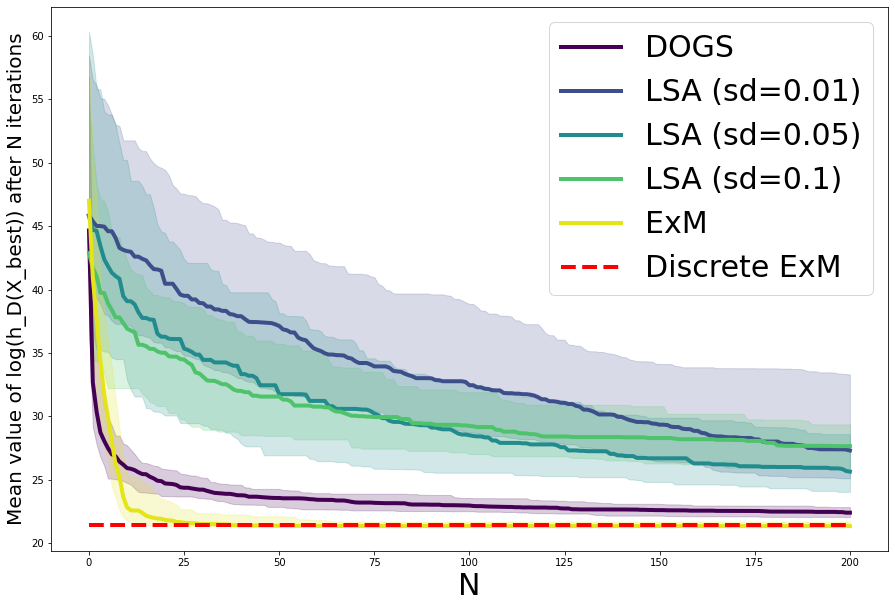

Average time for one realization of 200 iterations of DOGS: 2.569sec
Average time for one realization of 200 iterations of LSA: 0.098sec
Average time for one realization of 200 iterations of ExM: 0.669sec
Average time for one realization of Discrete ExM: 0.593sec


In [19]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis=plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)

for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.24), alpha=.2)

plt.legend(labels=["DOGS", "LSA (sd=0.01)", "LSA (sd=0.05)", "LSA (sd=0.1)", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec')
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

We see than in this setting (and for rectangular spaces in general), the continuous and discrete exchange method both work really well.

In [20]:
#Comaprison in dimension 2 for polynomial regression.

PHI = PHImono(2, 3)

OD = OptDesign(PHI, [0, 0], [1, 1], nbpoint=50, A_prior=100)
algo_tuple = (DOGS(OD), LSA(OD, 0.01), LSA(OD, 0.05), LSA(OD, 0.1), ExM(OD))
depth = 200 #Number of iteration of each algorithm.
N_test = 50 #Number of repetition of each algorithm.
quantile = 0.05 #Quantile used for plotting the shaded area.

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
    
#Testing Discrete_ExM separately.    
a = 0.35880/2
b = 0.48/2
CP = np.array([[0.5+a, 0], [0.5-a, 0], [0.5+a, 1], [0.5-a, 1], \
               [0, 0.5+a], [0, 0.5-a], [1, 0.5+a], [1, 0.5-a], \
               [0.5+b, 0.5+b], [0.5+b, 0.5-b], [0.5-b, 0.5+b], [0.5-b, 0.5-b]])

Algo_10grid_withCP = Discrete_ExM(OD, size=10, CP=CP)
N_discrete_test = 5 #In simple cases there is very little variance in the output of Discrete_ExM so there is
#no need to run a lot of tests.

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt2 = Algo_10grid_withCP.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt2)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

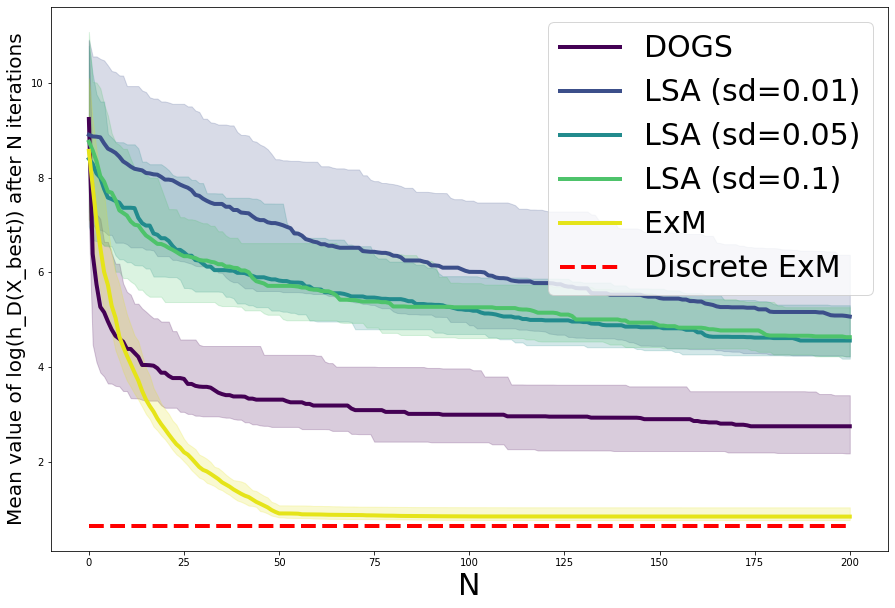

Average time for one realization of 200 iterations of DOGS: 3.118sec
Average time for one realization of 200 iterations of LSA: 0.114sec
Average time for one realization of 200 iterations of ExM: 1.603sec
Average time for one realization of Discrete ExM: 3.623sec


In [21]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis=plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)

for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.24), alpha=.2)

plt.legend(labels=["DOGS", "LSA (sd=0.01)", "LSA (sd=0.05)", "LSA (sd=0.1)", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec')
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

The relative performance of each algorithm seems to be unchanged in the Bayesian setting.

In [22]:
#Comaprison in dimension 4 for regression on trigonometric polynomials with degree <= 2.

def PHI(P):
    return np.vstack((0*P[:, 0]+1, np.cos(P[:, 0]), np.cos(P[:, 1]), np.cos(P[:, 2]), np.cos(P[:, 3]), np.cos(2*P[:, 0]), \
                      np.cos(2*P[:, 1]), np.cos(2*P[:, 2]), np.cos(2*P[:, 3]), np.cos(P[:, 0]+P[:, 1]), \
                      np.cos(P[:, 0]+P[:, 2]), np.cos(P[:, 0]+P[:, 3]), np.cos(P[:, 1]+P[:, 2]), np.cos(P[:, 1]+P[:, 3]), \
                      np.cos(P[:, 2]+P[:, 3]))).T

OD = OptDesign(PHI, [0, 0, 0, 0], [1, 1, 1, 1])
algo_tuple = (DOGS(OD), LSA(OD, 0.01), LSA(OD, 0.05), LSA(OD, 0.1), ExM(OD))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_6grid = Discrete_ExM(OD, size = 6)
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt2 = Algo_6grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt2)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

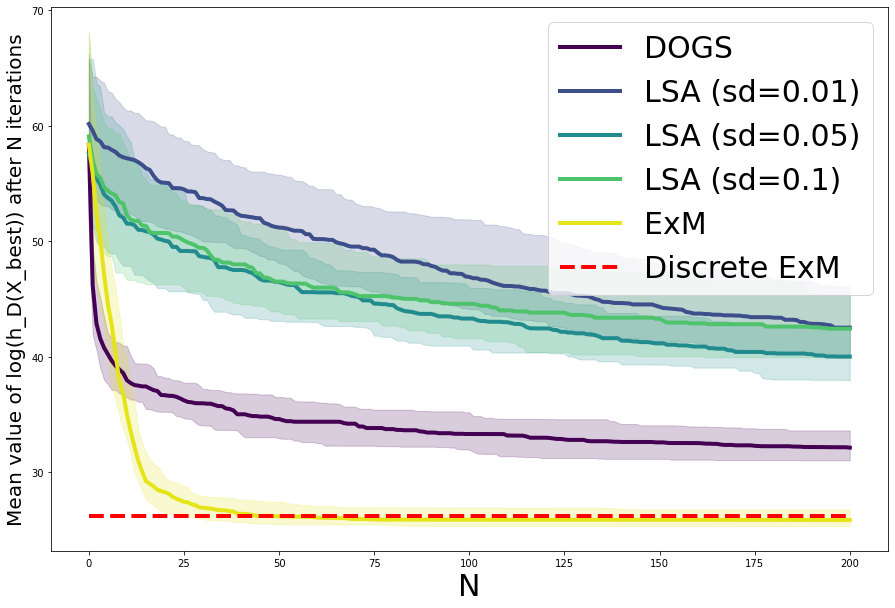

Average time for one realization of 200 iterations of DOGS: 4.009sec
Average time for one realization of 200 iterations of LSA: 0.059sec
Average time for one realization of 200 iterations of ExM: 0.924sec
Average time for one realization of Discrete ExM: 6.868sec


In [23]:
#Plotting the results

plt.figure(figsize = (15, 10))
viridis=plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.24), alpha=.2)

plt.legend(labels=["DOGS", "LSA (sd=0.01)", "LSA (sd=0.05)", "LSA (sd=0.1)", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

# 2. Non Rectangular Design Spaces

Defining an optimal design problem for non rectangular spaces is a bit more complicated. It requires a function *cara* that takes any $n\times d$ array of the form
$$\begin{pmatrix}x_1\\ \vdots\\ x_n\end{pmatrix},$$
where $d$ is the dimension of the design space, and returns a boolean vector $v$ where $v[i]$ is *True* iff $x_i$ is in the design space. It is possible to add a function *Urand* that takes any integer $n\geq 1$ and returns an $n\times d$ array of $n$ points generated uniformly and independantly on the design space (Otherwise, a rejection method using the *cara* function is used). Finally, in dimension 2, it is possible (but not necessary) to specify a *plot_fun* function that modify the $ax$ parameter of a matplotlib plot to draw the design space. Moreover, just like in the rectangular case, it is also necessary to specify the *PHI* function and the extremum points of a $d$-dimensional rectangle surronding the design space. The full syntax is *OptDesign(PHI , lower_point , upper_point , nbpoint = None , cara = None , Urand = None , plot_fun = None)*.

## 2.1. Three circles

As a first example, we consider the desing space $\Omega=B((0,0),1)\cup B((2,0),1)\cup B((1,\sqrt{3}),1)$.
We also consider that the regressing functions are the monomials with degree $\leq 3$ and the number of points in the designs are the same as the number of regressing functions.

log D-optimality criterion for this random design chosen with a uniform distribution: 1.0064027963668423


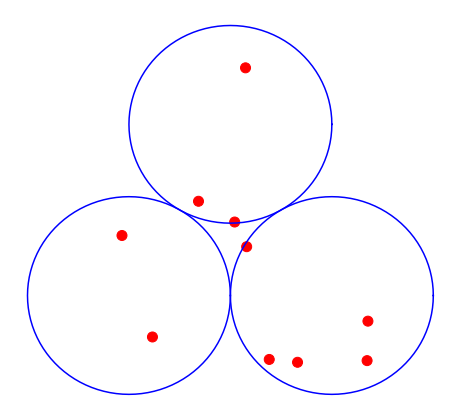

In [24]:
PHI = PHImono(2, 3)

def CircCara(P): #Characteristic function of the design space.
    Bool_Ar = np.logical_or(P[:, 0]**2+P[:, 1]**2 <= 1, (P[:, 0]-2)**2+P[:, 1]**2 <= 1)
    Bool_Ar = np.logical_or(Bool_Ar, (P[:, 0]-1)**2+(P[:, 1]-np.sqrt(3))**2 <= 1)
    return(Bool_Ar)

def CircRand(n): #Generates i.i.d. designs with uniform distribution on the design space (optional).
    A = np.random.rand(n, 2)
    a = np.random.randint(low=1, high=4, size=n)
    return np.vstack((np.sqrt(A[:, 0])*np.cos(2*np.pi*A[:, 1])+2*(a == 1)+1*(a == 2), \
                      np.sqrt(A[:, 0])*np.sin(2*np.pi*A[:, 1])+np.sqrt(3)*(a == 2))).T

def Circplot(ax): #Plots the design space (optional).
    ang = 2*np.pi*np.arange(0, 1.01, 0.01)
    ax.plot(np.cos(ang), np.sin(ang), 'b')
    ax.plot(2+np.cos(ang), np.sin(ang), 'b')
    ax.plot(1+np.cos(ang), np.sqrt(3)+np.sin(ang), 'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI, [-1, -1], [3, 1+np.sqrt(3)], cara=CircCara, Urand=CircRand, plot_fun=Circplot)

P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P, crit="D"))
OD.plot(P)

Here is an exemple of a design generated by each algorithm and a comparison of their performances.

log D-optimality criterion for one realization of DOGS after 200 iterations: -24.26764714764066
log D-optimality criterion for one realization of LSA after 2000 iterations: -23.79996268013007
log D-optimality criterion for one realization of ExM after 200 iterations: -23.282211079546446


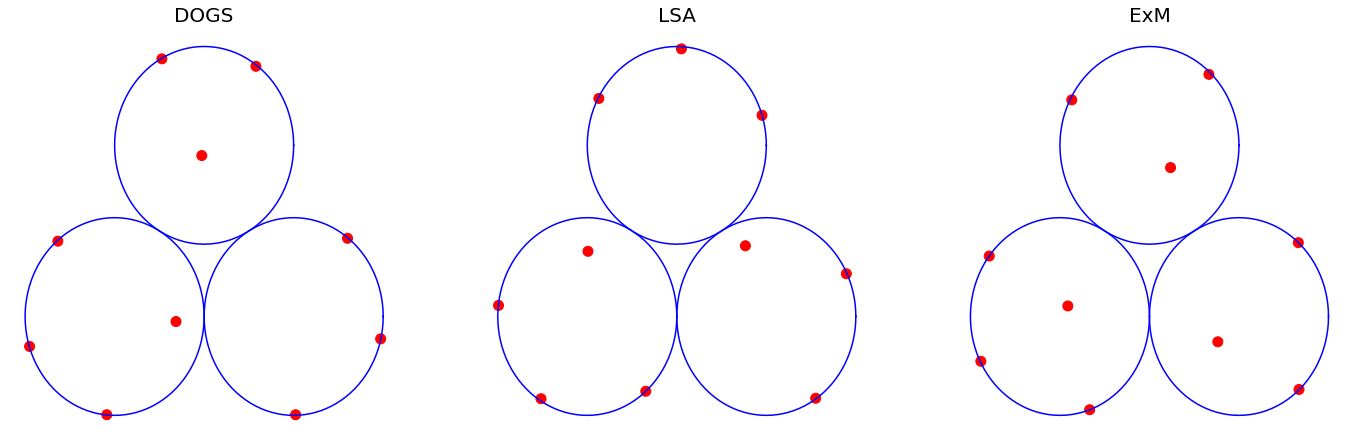

In [25]:
Algo_DOGS = DOGS(OD, 50)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end=" ")
print(OD.opt(P1))

Algo_LSA = LSA(OD, 0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for one realization of LSA after 2000 iterations:", end=" ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end=" ")
print(OD.opt(P3))

fig=OD.plot((P1, P2, P3), modify_plot=True)
fig.axes[0].set_title("DOGS", fontsize=20)
fig.axes[1].set_title("LSA", fontsize=20)
fig.axes[2].set_title("ExM", fontsize=20)
fig

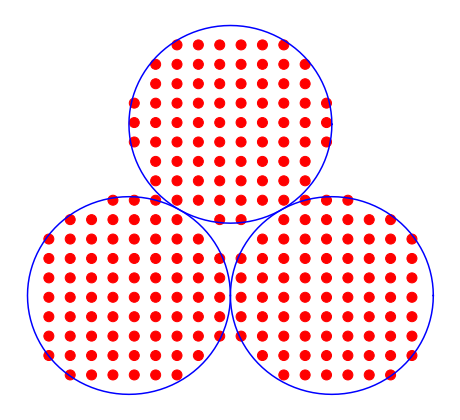

There are 228 candidate points used by Algo_20grid.
log D-optimality criterion for one realization of Discrete_ExM: -23.131084305575644


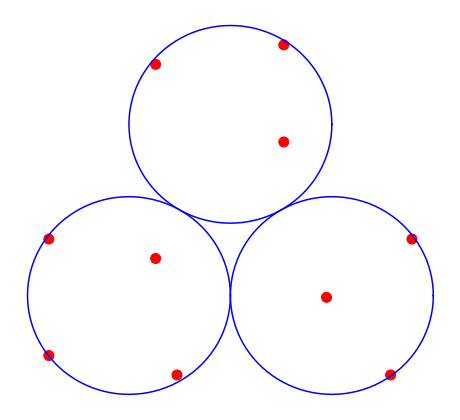

In [26]:
Algo_20grid = Discrete_ExM(OD, size=20)
Algo_20grid.show()
print("There are "+str(Algo_20grid.num_point())+" candidate points used by Algo_20grid.")

P4 = Algo_20grid.simulate()
print("log D-optimality criterion for one realization of Discrete_ExM:", end=" ")
print(OD.opt(P4))
OD.plot(P4)

Now, we compare all algorithms for this design space.

In [27]:
algo_tuple = (DOGS(OD), LSA(OD, 0.01), LSA(OD, 0.05), LSA(OD, 0.1), ExM(OD))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_20grid = Discrete_ExM(OD, size=20)
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_20grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

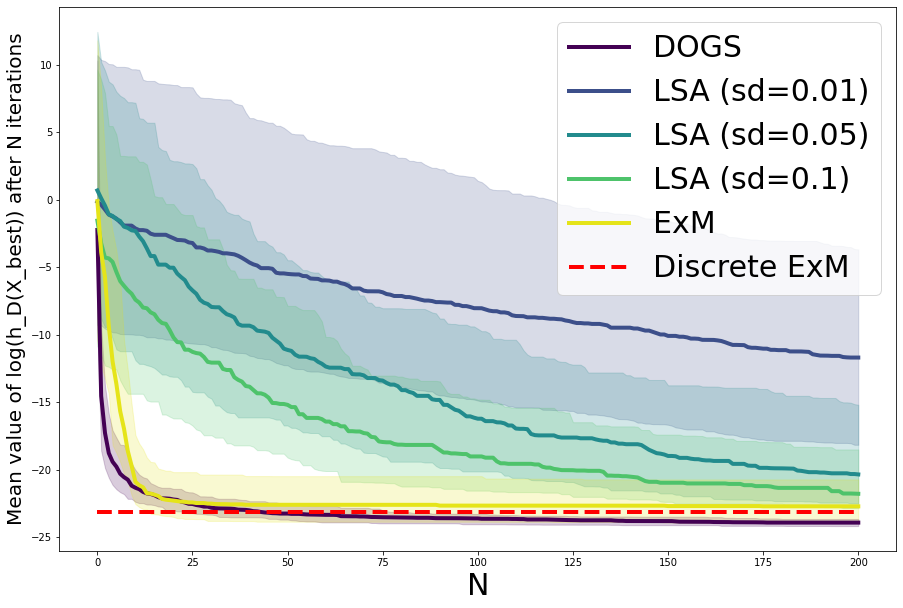

Average time for one realization of 200 iterations of DOGS: 2.565sec
Average time for one realization of 200 iterations of LSA: 0.114sec
Average time for one realization of 200 iterations of ExM: 3.812sec
Average time for one realization of Discrete ExM: 1.380sec


In [28]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis=plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.24), alpha=.2)

plt.legend(labels = ["DOGS", "LSA (sd=0.01)", "LSA (sd=0.05)", "LSA (sd=0.1)", "ExM", "Discrete ExM"], fontsize=30)
plt.xlabel('N', fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

This time, since we are in a non-rectangular design space, ExM shows its limitations and DOGS takes the lead.

## 2.2. The Moon

As a second example, we consider the desing space $\Omega=B((-0.2,0),0.6)\backslash B((0.6,0),0.4)$. This is the same design space as in the paper of De Castro et al.
We also consider that the regressing functions are the monomials with degree $\leq 2$ and that the number of points in the designs is $50$.

log D-optimality criterion for this random design chosen with a uniform distribution: -2.3299291308754597


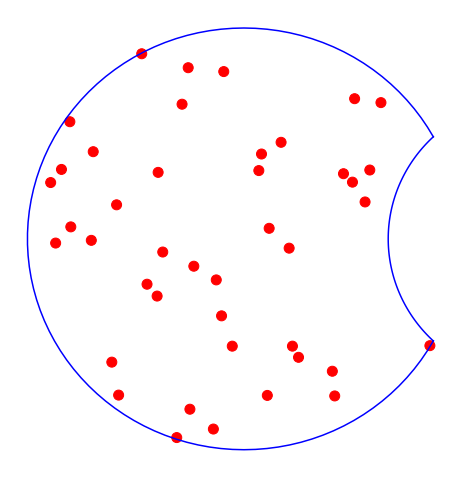

In [29]:
PHI = PHImono(2, 2)

def MoonCara(P): #Characteristic function of the design space.
    Bool_Ar = np.logical_and((P[:, 0]+0.2)**2+P[:, 1]**2 <= 0.36, (P[:, 0]-0.6)**2+P[:, 1]**2 >= 0.16)
    return(Bool_Ar)

def MoonRand(n): #Generates i.i.d. designs with uniform distribution on the design space (optional).
    A = np.random.rand(n, 2)
    P = np.vstack((-0.2+0.6*np.sqrt(A[:, 0])*np.cos(2*np.pi*A[:, 1]), 0.6*np.sqrt(A[:, 0])*np.sin(2*np.pi*A[:, 1])))
    P = P.T
    P = P[MoonCara(P), :]
    while P.shape[0]<n:
        A = np.random.rand(n, 2)
        P2 = np.vstack((-0.2+0.6*np.sqrt(A[:, 0])*np.cos(2*np.pi*A[:, 1]), 0.6*np.sqrt(A[:, 0])*np.sin(2*np.pi*A[:, 1])))
        P2 = P2.T
        P2 = P2[MoonCara(P2), :]
        P = np.vstack((P, P2))
    return P[:n, :]

def Moonplot(ax): #Plots the design space (optional).
    ang1 = np.arccos((13/40+0.2)/0.6)
    ANG1 = np.linspace(ang1, 2*np.pi-ang1, 100)
    ang2 = np.arccos((13/40-0.6)/0.4)
    ANG2 = np.linspace(ang2, 2*np.pi-ang2, 100)
    ax.plot(-0.2+0.6*np.cos(ANG1), 0.6*np.sin(ANG1), 'b')
    ax.plot(0.6+0.4*np.cos(ANG2), 0.4*np.sin(ANG2), 'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI, [-0.8, -0.6], [0.325, 0.6], nbpoint=42, cara=MoonCara, Urand=MoonRand, plot_fun=Moonplot)
P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P, crit="D"))
OD.plot(P)

In their article, De castro et al. found the following optimal design:

log D-optimality criterion of the design: -5.999032656277131


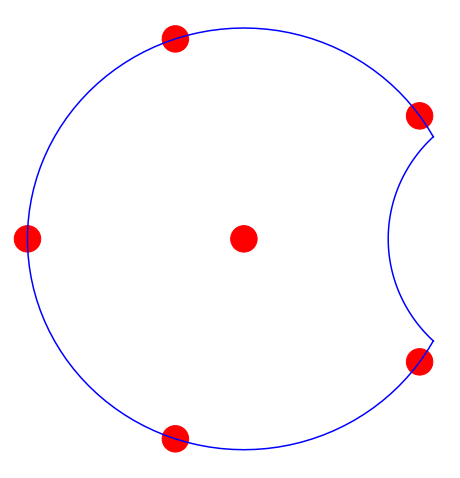

In [30]:
P_opt = np.array([[-0.39, -0.569], [-0.7999, 0], [-0.2, 0], [0.287, -0.35], [-0.39, 0.569], [0.287, 0.35]])
P_opt = np.vstack((P_opt, P_opt, P_opt, P_opt, P_opt, P_opt, P_opt))
print("log D-optimality criterion of the design:", end=" ")
print(OD.opt(P_opt))
OD.plot(P_opt)

Here is an exemple of a design generated by each algorithm and a comparison of their performances. We can already see in the examples that the designs closer to the results from De Castro et al. are the one generated by DOGS.

log D-optimality criterion for one realization of DOGS after 200 iterations: -5.671092092626359
log D-optimality criterion for one realization of LSA after 2000 iterations: -4.970801626951753
log D-optimality criterion for one realization of ExM after 200 iterations: -5.089443967522668


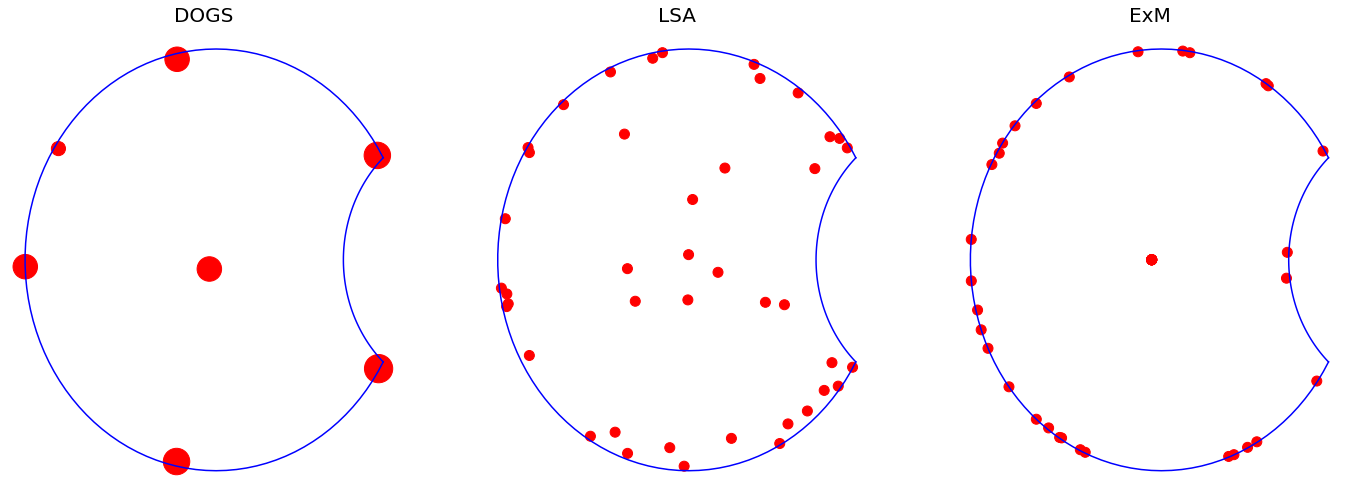

In [31]:
Algo_DOGS = DOGS(OD)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end=" ")
print(OD.opt(P1))

Algo_LSA = LSA(OD,0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for one realization of LSA after 2000 iterations:", end=" ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end=" ")
print(OD.opt(P3))

fig = OD.plot((P1,P2,P3),modify_plot=True)
fig.axes[0].set_title("DOGS", fontsize=20)
fig.axes[1].set_title("LSA", fontsize=20)
fig.axes[2].set_title("ExM", fontsize=20)
fig

And we finish by comparing the performances of all algorithms for this design space.

In [32]:
algo_tuple = (DOGS(OD), LSA(OD, 0.01), LSA(OD, 0.05), LSA(OD, 0.1), ExM(OD))
depth = 200
N_test = 50
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth, N_test, progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res, axis=0)]
    List_quantile_low += [np.quantile(sim_res, quantile, axis=0)]
    List_quantile_high += [np.quantile(sim_res, 1-quantile, axis=0)]
    
Algo_6grid = Discrete_ExM(OD, size = 20)
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_6grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end=" ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% 

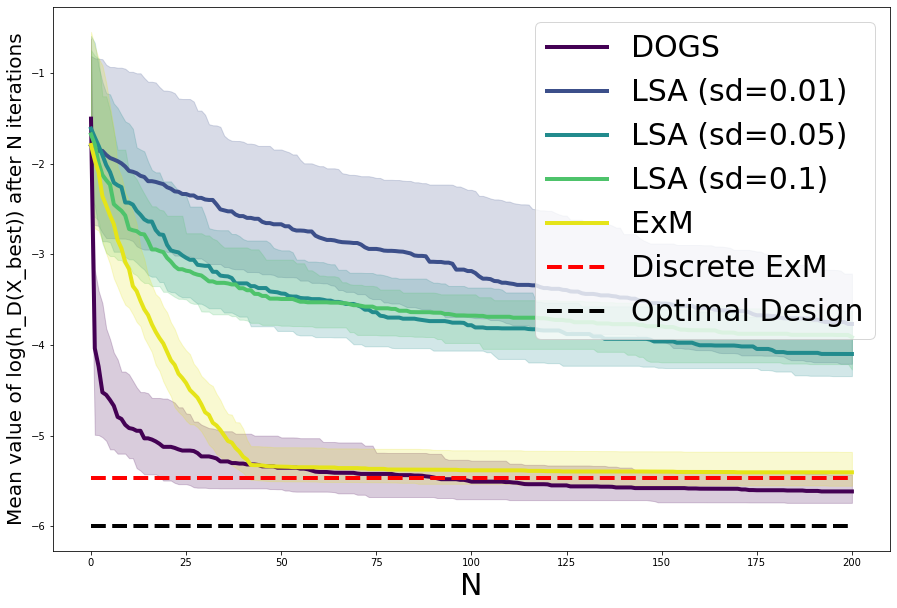

Average time for one realization of 200 iterations of DOGS: 1.373sec
Average time for one realization of 200 iterations of LSA: 0.086sec
Average time for one realization of 200 iterations of ExM: 2.836sec
Average time for one realization of Discrete ExM: 4.668sec


In [33]:
#Plotting the results

plt.figure(figsize=(15, 10))
viridis = plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k], linewidth=4, color=viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0, depth], [m, m], 'r--', linewidth=4)
plt.plot([0, depth], [OD.opt(P_opt), OD.opt(P_opt)], '--', color="black", linewidth=4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color=viridis(k*0.24), alpha=.2)

plt.legend(labels=["DOGS", "LSA (sd=0.01)", "LSA (sd=0.05)", "LSA (sd=0.1)", "ExM", "Discrete ExM", "Optimal Design"], fontsize = 30)
plt.xlabel('N', fontsize=30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations', fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');